In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from tensorflow import keras
import pandas as pd
import random

In [2]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  tf.experimental.numpy.random.seed(seed)

set_seed()
project_dir = os.path.dirname(os.getcwd())

In [3]:
model_mn2 = keras.applications.MobileNetV2(
    input_shape=None, alpha=1.0, include_top=True, weights='imagenet',
    input_tensor=None, pooling=None, classes=1000
)
layer_name = 'block_15_add'
feature_extractor = keras.models.Model(inputs=model_mn2.input, outputs=model_mn2.get_layer(layer_name).output)

In [4]:
models_path = os.path.join(project_dir, 'models')
model_mobilenetv2_regularized = tf.keras.models.load_model(os.path.join(models_path, 'model_mobilenetv2_regularized_plantdoc'))
model_squeeze_excite_resnet = tf.keras.models.load_model(os.path.join(models_path, 'model_squeeze_excite_resnet_plantdoc'))
model_pca_based = tf.keras.models.load_model(os.path.join(models_path, 'model_pca_based_plantdoc'))

In [5]:
diseases_names = []
dataset_path = os.path.join(project_dir, 'datasets', 'encoded', 'PlantDoc')

for diseases in os.listdir(os.path.join(dataset_path, 'train')):
    diseases_names += [diseases.split('.npy')[0]]

diseases_names.sort()
plant_name_to_id = {plant: i for i, plant in enumerate(diseases_names)}

In [6]:
instances = {}
labels = {}

for set_kind in ["test", "train", "val"]:
    X_per_class = []
    y_per_class = []

    for i, file in enumerate(os.listdir(os.path.join(dataset_path, set_kind))):
        print(f"\r[{i}] {set_kind}/{file}", end='')
        plants_encoded = np.load(os.path.join(dataset_path, set_kind, file))
        plant_name = file.split('.npy')[0]

        X_per_class += [plants_encoded.reshape([plants_encoded.shape[0], 49, 160])]
        y_per_class += [plant_name_to_id[plant_name] for _ in range(plants_encoded.shape[0])]

    instances[set_kind] = np.concatenate(X_per_class)
    labels[set_kind] = np.array(y_per_class)

[26] val/Tomato Septoria leaf spot.npyyyy

In [7]:
n_classes = len(diseases_names)

X_train = instances['train']
y_train = np.eye(n_classes)[labels['train']]


X_valid = instances['val']
y_valid = np.eye(n_classes)[labels['val']]

X_test = instances['test']
y_test = np.eye(n_classes)[labels['test']]

In [8]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow.image import random_crop
from tensorflow.image import random_contrast
from tensorflow.image import random_brightness
from tensorflow.image import random_flip_left_right
from tensorflow.image import random_hue
from tensorflow.image import random_jpeg_quality
from tensorflow.image import random_saturation
from tensorflow.errors import InvalidArgumentError
import matplotlib.pyplot as plt

In [9]:
def get_crop_size(img, minprop=0.7):
    def rand_prop(x):
        return x + (1. - x) * np.random.random()

    height, width, chanells = img.shape
    height_prop = 1.
    width_prop = 1.

    if height > width:
        height_prop = rand_prop(minprop)
        width_prop = rand_prop(height_prop)
    else:
        width_prop = rand_prop(minprop)
        height_prop = rand_prop(width_prop)

    height = np.floor(height_prop * height).astype(int)
    width = np.floor(width_prop * width).astype(int)
    return (height, width, chanells)

In [10]:
def apply_random_transforms(img):
    img = random_rotation(img, 20, row_axis=0, col_axis=1, channel_axis=2, fill_mode='reflect')
    img = random_contrast(img, 0.8, 1.2)
    img = random_brightness(img, 0.08)
    img = random_hue(img, 0.025)
    img = random_saturation(img, 0.85, 1.15)
    img = random_jpeg_quality(img, 75, 95)
    img = random_flip_left_right(img)
    return random_crop(img, get_crop_size(img, 0.67)).numpy()

def get_augmented_image(img):
    return Image.fromarray(apply_random_transforms(np.array(img.convert('RGB')))).resize((224, 224))

In [11]:
test_path = os.path.join(project_dir, 'datasets', 'augmented', 'PlantDoc', 'test')
all_dirs = []
for directory in os.listdir(test_path):
    all_dirs += [directory]

In [12]:
for i, disease in enumerate(all_dirs):
    print("[{:03}] '{}'".format(i, disease))
    original_photos = []
    photos_names = []

    for j, file in enumerate(os.listdir(os.path.join(test_path, disease))):
        with Image.open(os.path.join(test_path, disease, file)) as img:
            original_photos += [img.copy()]
            photos_names += [os.path.join(test_path, disease, file)]


    dest = os.path.join(os.path.abspath(os.path.join(test_path, os.pardir)), 'ensemble_test_aug', disease)
    os.makedirs(os.path.dirname(dest), exist_ok=True)

    for j, img in enumerate(original_photos):
        print("\rPhoto no: {}".format(j), end='')
        os.makedirs(os.path.dirname(dest + "/{}/".format(j)), exist_ok=True)
        for counter in range(1, 20+1):
            try:
                get_augmented_image(img).save(
                    dest + "/{}/{}_{}.jpg".format(j, disease.replace(' ', '_'), counter)
                )
                print("\r{}".format(counter), end='')
            except Exception as e:
                print("\nError encountered: ", photos_names[j])
                print(e)

[000] 'Apple leaf'
20[001] 'Apple rust leaf'
20[002] 'Apple Scab Leaf'
20[003] 'Bell_pepper leaf'
20[004] 'Bell_pepper leaf spot'
20[005] 'Blueberry leaf'
20[006] 'Cherry leaf'
20[007] 'Corn Gray leaf spot'
20[008] 'Corn leaf blight'
20[009] 'Corn rust leaf'
20[010] 'grape leaf'
20[011] 'grape leaf black rot'
20[012] 'Peach leaf'
20[013] 'Potato leaf early blight'
20[014] 'Potato leaf late blight'
20[015] 'Raspberry leaf'
20[016] 'Soyabean leaf'
20[017] 'Squash Powdery mildew leaf'
20[018] 'Strawberry leaf'
20[019] 'Tomato Early blight leaf'
20[020] 'Tomato leaf'
20[021] 'Tomato leaf bacterial spot'
20[022] 'Tomato leaf late blight'
20[023] 'Tomato leaf mosaic virus'
20[024] 'Tomato leaf yellow virus'
20[025] 'Tomato mold leaf'
20[026] 'Tomato Septoria leaf spot'
20oto no: 10

In [13]:
model_mnv2 = keras.models.Sequential([
    keras.layers.Input(shape=(224, 224, 3), dtype=tf.uint8),
    keras.layers.Lambda(lambda x: tf.cast(x, dtype=tf.float32)),
    keras.layers.Lambda(
        tf.keras.applications.mobilenet_v2.preprocess_input,
        name='preprocessing',
        input_shape=(224, 224, 3),
        dtype=tf.float32),
    feature_extractor,
    model_mobilenetv2_regularized
])

In [14]:
model_seresnet = keras.models.Sequential([
    keras.layers.Input(shape=(224, 224, 3), dtype=tf.uint8),
    keras.layers.Lambda(lambda x: tf.cast(x, dtype=tf.float32)),
    keras.layers.Lambda(
        tf.keras.applications.mobilenet_v2.preprocess_input,
        name='preprocessing',
        input_shape=(224, 224, 3),
        dtype=tf.float32),
    feature_extractor,
    model_squeeze_excite_resnet
])

In [15]:
pca_per_filter = [
    PCA(n_components=5).fit(X_train[..., i])
    for i in range(X_train.shape[-1])
]

class PCATransformer(keras.layers.Layer):
    def __init__(self, means, components, **kwargs):
        super().__init__(**kwargs)
        self.all_means = tf.reshape(tf.transpose(means), [1, 49, 160])
        self.all_components = tf.transpose(components, perm=[0, 2, 1])

    @tf.function
    def call(self, X):
        return tf.transpose(tf.map_fn(
            lambda inp: inp[0] @ inp[1],
            (tf.transpose(X - self.all_means, perm=[2, 0, 1]), self.all_components),
            fn_output_signature=tf.TensorSpec(shape=[None, 5])
        ), perm=[1, 2, 0])

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape((batch_input_shape[0], 5, 160))

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "mean": self.means.numpy(), "components": self.components.numpy()}


all_means = np.array([filter.mean_ for filter in pca_per_filter])
all_components = np.array([filter.components_ for filter in pca_per_filter])

model_pcadense = keras.models.Sequential([
    keras.layers.Input(shape=(224, 224, 3), dtype=tf.uint8),
    keras.layers.Lambda(lambda x: tf.cast(x, dtype=tf.float32)),
    keras.layers.Lambda(
        tf.keras.applications.mobilenet_v2.preprocess_input,
        name='preprocessing',
        input_shape=(224, 224, 3),
        dtype=tf.float32),
    feature_extractor,
    keras.layers.Reshape(target_shape=[49, 160]),
    PCATransformer(tf.constant(all_means), tf.constant(all_components)),
    keras.layers.Flatten(input_shape=[5, 160]),
    model_pca_based
])

In [16]:
hits_mnv2 = np.zeros((39, 20), dtype=np.int32)

for i, disease in enumerate(all_dirs):
    print("[{:03}] '{}'".format(i, disease))
    correct_id = plant_name_to_id[disease]

    for counter in os.listdir(os.path.join(os.path.abspath(os.path.join(test_path, os.pardir)), 'ensemble_test_aug', disease)):
        origin = os.path.join(os.path.abspath(os.path.join(test_path, os.pardir)), 'ensemble_test_aug', disease, counter)
        batch = tf.keras.utils.image_dataset_from_directory(origin, labels=None, batch_size=20, image_size=(224, 224))

        for x in batch.take(1):
            preds_proba = model_mnv2(x)
            preds = np.argmax(np.cumsum(np.sqrt(preds_proba.numpy()), axis=0), axis=1)
            hit_or_miss = np.where(preds == correct_id, 1, 0)
            hits_mnv2[correct_id] += hit_or_miss

[000] 'Apple leaf'
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
[001] 'Apple rust leaf'
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
[002] 'Apple Scab Leaf'
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classe

In [17]:
hits_seresnet = np.zeros((39, 20), dtype=np.int32)

for i, disease in enumerate(all_dirs):
    print("[{:03}] '{}'".format(i, disease))
    correct_id = plant_name_to_id[disease]

    for counter in os.listdir(os.path.join(os.path.abspath(os.path.join(test_path, os.pardir)), 'ensemble_test_aug', disease)):
        origin = os.path.join(os.path.abspath(os.path.join(test_path, os.pardir)), 'ensemble_test_aug', disease, counter)
        batch = tf.keras.utils.image_dataset_from_directory(origin, labels=None, batch_size=20, image_size=(224, 224))

        for x in batch.take(1):
            preds_proba = model_mnv2(x)
            preds = np.argmax(np.cumsum(np.sqrt(preds_proba.numpy()), axis=0), axis=1)
            hit_or_miss = np.where(preds == correct_id, 1, 0)
            hits_seresnet[correct_id] += hit_or_miss

[000] 'Apple leaf'
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
[001] 'Apple rust leaf'
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
[002] 'Apple Scab Leaf'
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classe

In [18]:
hits_pca = np.zeros((39, 20), dtype=np.int32)

for i, disease in enumerate(all_dirs):
    print("[{:03}] '{}'".format(i, disease))
    correct_id = plant_name_to_id[disease]

    for counter in os.listdir(os.path.join(os.path.abspath(os.path.join(test_path, os.pardir)), 'ensemble_test_aug', disease)):
        origin = os.path.join(os.path.abspath(os.path.join(test_path, os.pardir)), 'ensemble_test_aug', disease, counter)
        batch = tf.keras.utils.image_dataset_from_directory(origin, labels=None, batch_size=20, image_size=(224, 224))

        for x in batch.take(1):
            preds_proba = model_mnv2(x)
            preds = np.argmax(np.cumsum(np.sqrt(preds_proba.numpy()), axis=0), axis=1)
            hit_or_miss = np.where(preds == correct_id, 1, 0)
            hits_pca[correct_id] += hit_or_miss

[000] 'Apple leaf'
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
[001] 'Apple rust leaf'
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
[002] 'Apple Scab Leaf'
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classe

In [19]:
count_images = 0

for i, disease in enumerate(all_dirs):
    print("[{:03}] '{}'".format(i, disease))
    correct_id = plant_name_to_id[disease]

    count_images +=  len(os.listdir(os.path.join(test_path, disease)))

print(count_images)

[000] 'Apple leaf'
[001] 'Apple rust leaf'
[002] 'Apple Scab Leaf'
[003] 'Bell_pepper leaf'
[004] 'Bell_pepper leaf spot'
[005] 'Blueberry leaf'
[006] 'Cherry leaf'
[007] 'Corn Gray leaf spot'
[008] 'Corn leaf blight'
[009] 'Corn rust leaf'
[010] 'grape leaf'
[011] 'grape leaf black rot'
[012] 'Peach leaf'
[013] 'Potato leaf early blight'
[014] 'Potato leaf late blight'
[015] 'Raspberry leaf'
[016] 'Soyabean leaf'
[017] 'Squash Powdery mildew leaf'
[018] 'Strawberry leaf'
[019] 'Tomato Early blight leaf'
[020] 'Tomato leaf'
[021] 'Tomato leaf bacterial spot'
[022] 'Tomato leaf late blight'
[023] 'Tomato leaf mosaic virus'
[024] 'Tomato leaf yellow virus'
[025] 'Tomato mold leaf'
[026] 'Tomato Septoria leaf spot'
236


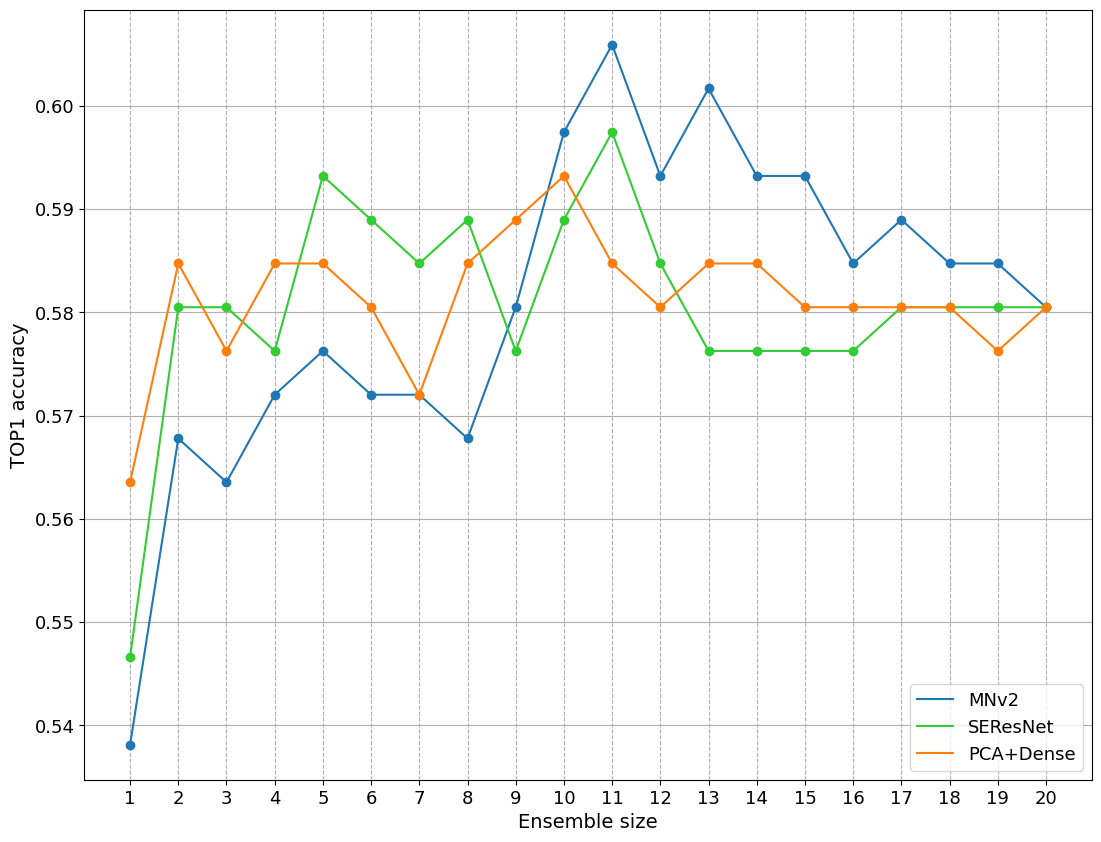

In [20]:
plt.figure(figsize=(13, 10))

plt.xlabel("Ensemble size", fontsize=14)
plt.ylabel("TOP1 accuracy", fontsize=14)

plt.xticks(range(1, 21), fontsize=13)
plt.yticks(np.arange(0.25, 0.96, 0.01), fontsize=13)
plt.grid(axis='x', linestyle='--')
plt.grid(axis='y', linestyle='-')

mnv2_acc = np.sum(hits_mnv2, axis=0) / count_images
plt.plot(range(1, 21), mnv2_acc, c="tab:blue", label="MNv2")
plt.scatter(range(1, 21), mnv2_acc, c="tab:blue", zorder=2)

seresnet_acc = np.sum(hits_seresnet, axis=0) / count_images
plt.plot(range(1, 21), seresnet_acc, c="limegreen", label="SEResNet")
plt.scatter(range(1, 21), seresnet_acc, c="limegreen", zorder=2)

pca_acc = np.sum(hits_pca, axis=0) / count_images
plt.plot(range(1, 21), pca_acc, c="tab:orange", label="PCA+Dense")
plt.scatter(range(1, 21), pca_acc, c="tab:orange", zorder=2)

plt.legend(fontsize=13, loc="lower right")
plt.savefig('plantdoc_ensamble.png')
plt.show()

